In [1]:
import numpy as np
import pandas as pd
import io

In [2]:
base_path = '/home/avemuri/DEV/Data/amazon_from_space/'

In [3]:
train_df = pd.read_csv(base_path+'train_v2.csv')
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer

import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
image_list = [f for f in glob.glob(base_path+'train-jpg/*.jpg')]
print(len(image_list))

40479


In [6]:
class AmazonDataset(Dataset):
    def __init__(self, base_folder, csv_file, folder_name, transform=None):
        self.csv_file = csv_file
        self.labels_df = pd.read_csv(base_path+csv_file)
        self.base_folder = base_folder
        self.image_list = [f for f in glob.glob(base_path+folder_name+'/*.jpg')]
        self.transform = transform
        self.mlb = MultiLabelBinarizer()
        self.labels = self.mlb.fit_transform(self.labels_df['tags'].str.split()).astype(np.float32)
        
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, index):
        image = Image.open(self.image_list[index])
        image = image.convert('RGB')
        # image = cv2.imread(self.image_list[index])
        
        label = torch.from_numpy(self.labels[index])
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [7]:
class GlobalMaxPool2D(nn.Module):
    '''
    Reduce to feature space
    '''
    def __init__(self):
        super(GlobalMaxPool2D, self).__init__()
        
    def forward(self, x):
        x =  torch.max(torch.max(x, 3, keepdim=False)[0], 2, keepdim=False)[0]
        return x


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, input):
        return input.view(input.size(0), -1)

class CNNModel(nn.Module):
    def __init__(self, n_classes, debug=False):
        super(CNNModel, self).__init__()
        
        
        self.conv11 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv13 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv21 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv23 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)
        
        self.conv31 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=3, stride=1, padding=1)
        self.conv33 = nn.Conv2d(in_channels=2048, out_channels=4096, kernel_size=3, stride=1, padding=1)
        
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1)
        
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.global_maxpool = GlobalMaxPool2D()
        self.fc1 = nn.Linear(in_features=4096, out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=256)
        self.fc3 = nn.Linear(in_features=256, out_features=n_classes)
        # self.fc4 = nn.Linear(in_features=256, out_features=n_classes)
        self.relu = nn.LeakyReLU(inplace=True)
        self.dropout2d = nn.Dropout2d()
        self.dropout = nn.Dropout()
        self.flatten = Flatten()
        self.sigmoid = nn.Sigmoid()
        

        self.debug = debug
        
    def forward(self, x):
        x = self.dropout2d(self.maxpool(self.conv13(self.relu(self.conv12(self.relu(self.conv11(x)))))))
        if self.debug:
            print(x.shape)
            
        x = self.dropout2d(self.maxpool(self.conv23(self.relu(self.conv22(self.relu(self.conv21(x)))))))
        if self.debug:
            print(x.shape)
            
        x = self.dropout2d(self.maxpool(self.conv33(self.relu(self.conv32(self.relu(self.conv31(x)))))))
        if self.debug:
            print(x.shape)
            
        x = self.global_maxpool(x)
#         x = self.flatten(x)
        if self.debug:
            print(x.shape)
            
        x = self.dropout(self.relu(self.fc1(x)))
        if self.debug:
            print(x.shape)
        x = self.dropout(self.relu(self.fc2(x)))
        if self.debug:
            print(x.shape)
        x = self.dropout(self.relu(self.fc3(x)))
        if self.debug:
            print(x.shape)
            
#         if self.debug:
#             print(x.shape)
#         x = self.maxpool(self.relu(self.conv2(x)))
#         x = self.dropout2d(x)
#         if self.debug:
#             print(x.shape)
#         x = self.maxpool(self.relu(self.conv3(x)))
#         if self.debug:
#             print(x.shape)
#         x = self.maxpool(self.relu(self.conv4(x)))
#         x = self.dropout2d(x)
#         if self.debug:
#             print(x.shape)
#         x = self.maxpool(self.relu(self.conv5(x)))
#         if self.debug:
#             print(x.shape)
        
#         # x = self.global_maxpool(x)
#         x = self.flatten(x)
#         x = self.dropout(x)
#         if self.debug:
#             print(x.shape)

#         x = self.fc1(x)
#         x = self.dropout(x)
#         if self.debug:
#             print(x.shape)
#         x = self.fc2(x)
#         x = self.dropout(x)
#         if self.debug:
#             print(x.shape)
#         x = self.fc3(x)
#         x = self.dropout(x)
#         if self.debug:
#             print(x.shape)
#         x = self.fc4(x)
#         if self.debug:
#             print(x.shape)

        
        return  x

In [8]:
train_dataset = AmazonDataset('/home/avemuri/DEV/Data/amazon_from_space/',
                              'train_v2.csv', 'train-jpg', transform=transforms.ToTensor())
# train_dataset = AmazonDataset('/home/avemuri/DEV/Data/amazon_from_space/',
#                               'test_v2.csv', 'train-jpg', transform=transforms.ToTensor())

In [9]:
random_seed = 42
shuffle_dataset = True
validation_split = 0.2
dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

batch_size = 10

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

print(len(train_loader), len(validation_loader))
image, label = next(iter(train_loader))
print(image.shape, label.shape)

3239 810
torch.Size([10, 3, 256, 256]) torch.Size([10, 17])


In [10]:
model = CNNModel(17, debug=True)
out = model(image)

torch.Size([10, 64, 128, 128])
torch.Size([10, 512, 64, 64])
torch.Size([10, 4096, 32, 32])
torch.Size([10, 4096])
torch.Size([10, 1024])
torch.Size([10, 256])
torch.Size([10, 17])


In [16]:
num_epochs = 1
learning_rate = 0.00001
n_classes = 17

model = CNNModel(n_classes, debug=False)
if torch.cuda.is_available():
    model.cuda()
# criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.MultiLabelSoftMarginLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)#, weight_decay=1e-4)
loss_list = []

for epoch in range(num_epochs):
    for iteration, (images, labels) in enumerate(train_loader):
        model.train()
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
        
        optimizer.zero_grad()
        labels_pred = model(images)
        loss = criterion(labels_pred, labels)
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            loss_list.append(loss.cpu().data)
            
            if iteration%200 == 0:
                accuracy = 0
                eval_loss = 0
                model.eval()
                for eval_iteration, (X, y) in enumerate(validation_loader):
                    if torch.cuda.is_available():
                        X = X.cuda()
                        y = y.cuda()

                    y_pred = model(X)
                    # total += y.size(0)

                    if torch.cuda.is_available():
                        eval_loss += criterion(y_pred, y).cpu().data
                    else:
                        eval_loss += criterion(y_pred, y).data
                
                print("{0}: {1} / {2} : {3} : {4}".format(epoch, iteration, len(train_loader), 
                                                          loss.cpu().data, 
                                                          eval_loss.cpu().data/len(validation_loader)))
                
            
            
plt.plot(np.arange(0,len(loss_list)), np.array(loss_list))



0: 0 / 3239 : 0.6864591836929321 : 0.686129093170166
0: 200 / 3239 : 0.44472646713256836 : 0.35636499524116516
0: 400 / 3239 : 0.4829641878604889 : 0.3470592498779297
0: 600 / 3239 : 0.45206722617149353 : 0.34217551350593567
0: 800 / 3239 : 0.49392935633659363 : 0.34629279375076294
0: 1000 / 3239 : 0.4901973009109497 : 0.34622323513031006


KeyboardInterrupt: 

In [17]:
validation_loader_plot = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                                     sampler=valid_sampler)

with torch.no_grad():
    loss_list.append(loss.cpu().data)
    gt_preds = []

    total = 0
    for eval_iteration, (X, y) in enumerate(validation_loader_plot):
        if torch.cuda.is_available():
            X = X.cuda()
            y = y.cuda()

        y_pred = model(X)

        gt_preds.append((y.cpu().numpy(), y_pred.cpu().numpy()))
        # total += y.size(0)

        # if torch.cuda.is_available():
        #     eval_loss += criterion(y_pred, y).cpu().data
        # else:
        #     eval_loss += criterion(y_pred, y).data

    # print("{0}: {1} / {2} : {3} {4}".format(epoch, iteration, len(train_loader), 
    #                                         loss.cpu().data, eval_loss.cpu().data/total))

print(len(gt_preds))



8095


[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]] [[-0. -2. -2. -2. -2.  0. -1. -2. -1. -1. -1. -1.  1. -1. -2. -2. -1.]]


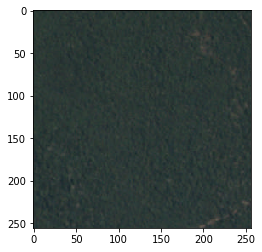

In [18]:
for index, (image, label) in enumerate(validation_loader_plot):
    image = np.moveaxis(np.squeeze(image.numpy()), (0,1,2), (2,0,1))
    plt.imshow(image)
    print(gt_preds[index][0], np.round(gt_preds[index][1]))
    break